# TinyML Autoencoder for ToyADMOS

Start by getting the data into the notebook. We will focus on the first case of toy car example, and use a subset of that dataset to train an autoencoder.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import sklearn.metrics

In [ ]:
NUMBER_OF_TRAINING_FILES = 1000
NUMBER_OF_TEST_FILES = 1000

In [2]:
training_path = "/Users/emjn/Documents/DTU/Datasets/ToyConveyor/case1/NormalSound_IND/"
test_path = "/Users/emjn/Documents/DTU/Datasets/ToyConveyor/case1/AnomalousSound_IND/"

# Get the file paths for the sound files in the training and test path
training_files_path = tf.io.gfile.glob(training_path + "*ch1*.wav")
test_files_path = tf.io.gfile.glob(test_path + "*ch1*.wav")

# Let us reduce the amount of training and test samples for the moment
training_files_path = training_files_path[:NUMBER_OF_TRAINING_FILES]
test_files_path = test_files_path[:NUMBER_OF_TEST_FILES]

In [3]:
# This is very slow, maybe it could be optimized
training_audio = []
test_audio = []

_, sr = librosa.load(training_files_path[0])

for audio_file in training_files_path:
    sample, _ = librosa.load(audio_file)
    training_audio.append(sample)
    
for audio_file in test_files_path:
    sample, _ = librosa.load(audio_file)
    test_audio.append(sample)
    

Now that we have the audio loaded into memory, we create spectrograms based on the audio.

In [4]:
FRAME_SIZE = 2048
HOP_SIZE = 512

In [5]:
def apply_stft(audio_sample):
    mel_spectrogram = librosa.feature.melspectrogram(audio_sample, sr=sr, n_fft=2048, hop_length=512, n_mels=256)
    return librosa.power_to_db(mel_spectrogram)

In [6]:
training_magnitudes = []
test_magnitudes = []

for audio in training_audio:
    training_magnitudes.append(apply_stft(audio))
for audio in test_audio:
    test_magnitudes.append(apply_stft(audio))
    
training_magnitudes = np.array(training_magnitudes)
test_magnitudes = np.array(test_magnitudes)

Let us visualize a spectrogram of one of the sound files

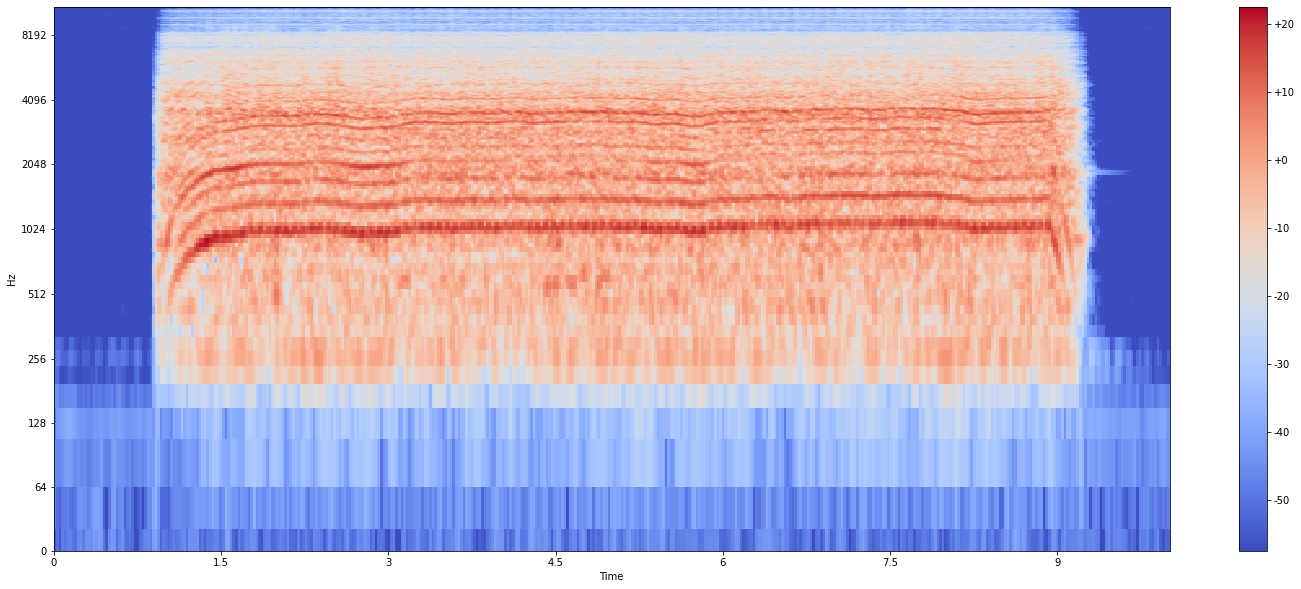

In [7]:
plt.figure(figsize=(25,10))
librosa.display.specshow(training_magnitudes[2], sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

## Defining the model
Having generated the spectrograms we now need to preprocess the them to be suitable for the network. 

In [8]:
training_magnitudes.shape


(1000, 256, 431)

We need to add a new dimension to the datasets to be able to work with tensorflows convolutions that expect dimensions that would normally be present in an image (dataset_dimension, x, y, channels)

In [9]:
training_magnitudes_4D = training_magnitudes[..., tf.newaxis]
test_magnitudes_4D = test_magnitudes[..., tf.newaxis]

# We pad the spectrograms to multiples of 4 to make max pooling and upsampling result in the same shape
x_train = tf.keras.layers.ZeroPadding2D(padding=((0,0),(1,0)))(training_magnitudes_4D)
x_test = tf.keras.layers.ZeroPadding2D(padding=((0,0),(1,0)))(test_magnitudes_4D)

x_train.shape

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-02-16 13:44:10.506306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-16 13:44:10.506432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TensorShape([1000, 256, 432, 1])

As it can be seen on the spectrogram plotted above, the current magnitudes range from about +35 to -45. It is problematic that the values include negative numbers as it will not be possible to reconstruct these using the ReLU activation function. Furthermore neural networks work the best in values ranging from 0-1.

Therefore we apply a shift and a scale to keep the magnitudes of the spectrograms inside this range.

In [10]:
# Getting the min and max value to compute the shift and scale
min_value = tf.reduce_min(x_train)
max_value = tf.reduce_max(x_train)

# Apply shift
x_train = tf.math.subtract(x_train, min_value)
x_test = tf.math.subtract(x_test, min_value)

# Apply scale

x_train = x_train / max_value
x_test = x_test / max_value

## Defining the model
We now define an autoencoder to take the preprocessed spectrograms as input.

In [11]:
encoder = tf.keras.models.Sequential()

encoder.add(tf.keras.layers.Conv2D(32, 3, padding="same",
                                   activation="relu", input_shape=x_train.shape[1:]))
encoder.add(tf.keras.layers.MaxPooling2D())

encoder.add(tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
encoder.add(tf.keras.layers.MaxPooling2D())

encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 432, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 216, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 216, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 108, 64)      0         
 2D)                                                             
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [12]:
decoder = tf.keras.models.Sequential()

decoder.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))
decoder.add(tf.keras.layers.UpSampling2D())

decoder.add(tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))
decoder.add(tf.keras.layers.UpSampling2D())

decoder.add(tf.keras.layers.Conv2D(1, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 108, 32)       18464     
                                                                 
 up_sampling2d (UpSampling2D  (None, 128, 216, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 216, 16)      4624      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 256, 432, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 432, 1)       145       
                                                                 
Total params: 23,233
Trainable params: 23,233
Non-trai

In [13]:
conv_autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder.outputs))

In [14]:
conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

In [15]:
history = conv_autoencoder.fit(x_train, x_train, epochs=50)

Epoch 1/50


2022-02-16 13:44:12.061725: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-16 13:44:12.235314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 13s 351ms/step - loss: 0.3973
Epoch 2/50
32/32 [==============================] - 11s 336ms/step - loss: 0.0327
Epoch 3/50
32/32 [==============================] - 11s 337ms/step - loss: 0.0273
Epoch 4/50
32/32 [==============================] - 11s 337ms/step - loss: 0.0244
Epoch 5/50
32/32 [==============================] - 11s 337ms/step - loss: 0.0222
Epoch 6/50
32/32 [==============================] - 11s 338ms/step - loss: 0.0200
Epoch 7/50
32/32 [==============================] - 11s 338ms/step - loss: 0.0180
Epoch 8/50
32/32 [==============================] - 11s 337ms/step - loss: 0.0167
Epoch 9/50
32/32 [==============================] - 11s 340ms/step - loss: 0.0159
Epoch 10/50
32/32 [==============================] - 11s 343ms/step - loss: 0.0154
Epoch 11/50
32/32 [==============================] - 11s 347ms/step - loss: 0.0153
Epoch 12/50
32/32 [==============================] - 11s 342ms/step - loss: 0.0146
Epoch 13/50
32/32 [=====

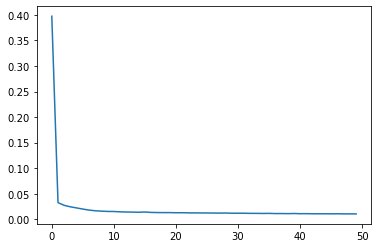

In [16]:
plt.plot(history.history["loss"], label="Training Loss")

## Save the model for another time
Good if training takes a long time

In [29]:
save_path = "./saved_tf_models/"
tf.saved_model.save(conv_autoencoder, save_path)

2022-02-16 14:16:03.896740: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_tf_models/assets


## Take a look at the reconstructions

In [30]:
reconstructions = conv_autoencoder.predict(x_train)

In [37]:
squeezed_reconstructions = tf.squeeze(reconstructions)

To get back to the original spectrogram scale we shift and scale the reconstructed spectrograms.

In [38]:
scaled_reconstructions = squeezed_reconstructions * max_value

shifted_reconstructions = tf.math.add(scaled_reconstructions, min_value)

### An original spectrogram

In [39]:
# Which spectrogram to visualize
spec_number=8

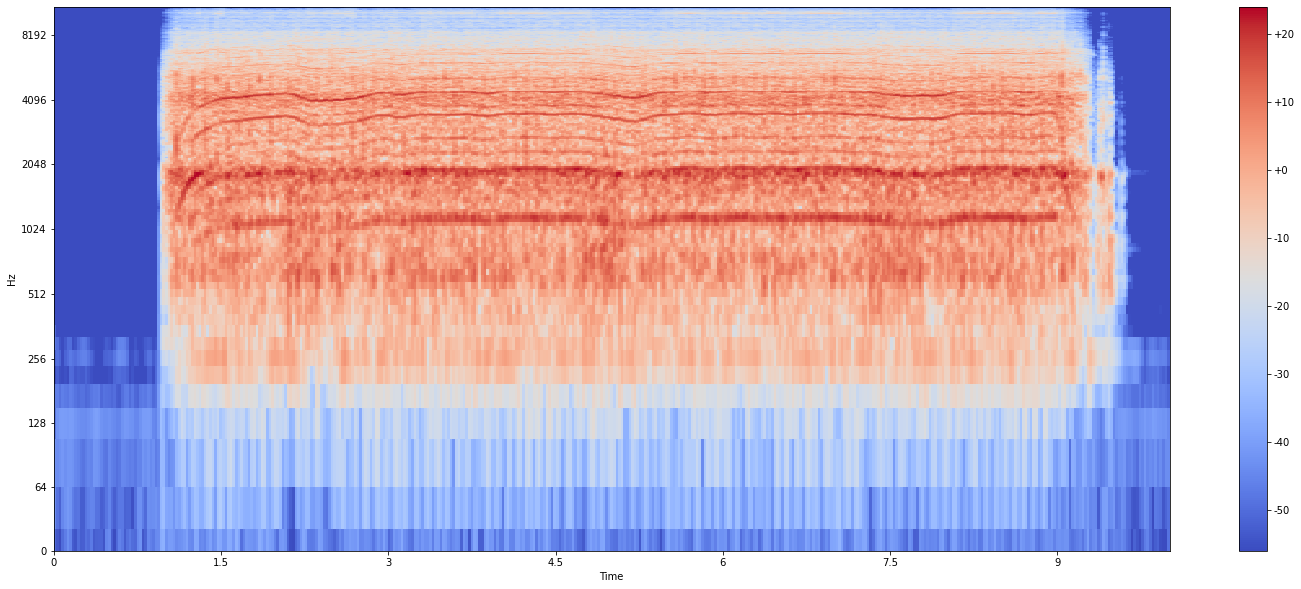

In [40]:
plt.figure(figsize=(25,10))
librosa.display.specshow(test_magnitudes[spec_number], sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

### The reconstructed image
There seems to be an issue with the autoencoder not generating negative numbers!

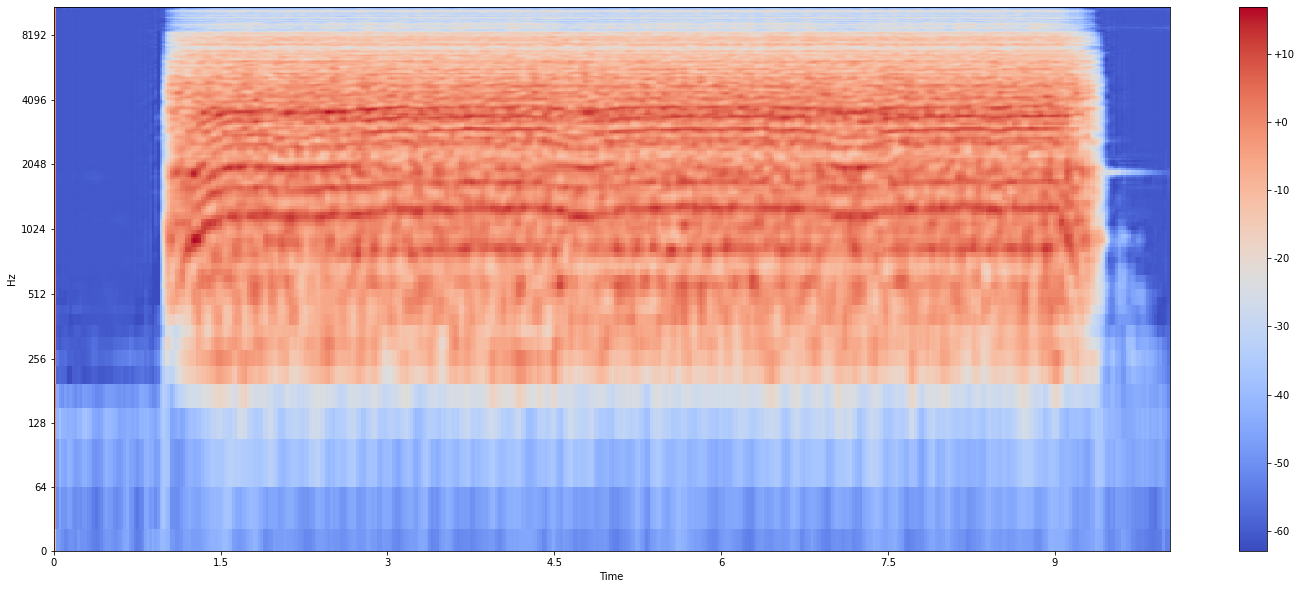

In [41]:
plt.figure(figsize=(25,10))
librosa.display.specshow(shifted_reconstructions[spec_number].numpy(), sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

## We now have to define a treshold for when to reject a sample as normal

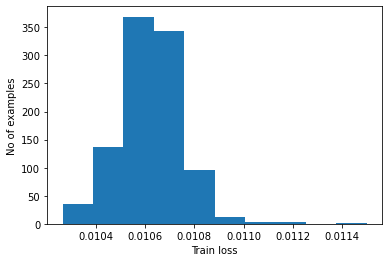

In [42]:
normal_reconstructions = reconstructions

# Reshape the input and reconstructions to work with tensorflow loss functions
reshaped_x_train = tf.reshape(x_train, [x_train.shape[0], tf.math.reduce_prod(x_train.shape[1:])])
reshaped_normal_reconstructions = tf.reshape(normal_reconstructions, [normal_reconstructions.shape[0], tf.math.reduce_prod(normal_reconstructions.shape[1:])])

normal_losses = tf.keras.losses.mse(reshaped_x_train, reshaped_normal_reconstructions)

plt.hist(normal_losses[None,:], bins=10)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

It seems that the loss of normal samples are around 0.028. Lets try to use the test set to see if we see higher reconstruction errors

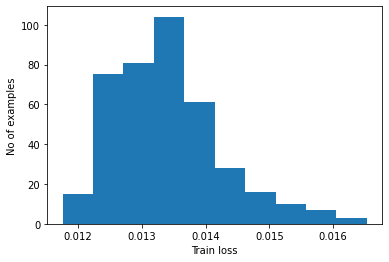

In [43]:
abnormal_reconstructions = conv_autoencoder.predict(x_test)

reshaped_x_test = tf.reshape(x_test, [x_test.shape[0], tf.math.reduce_prod(x_test.shape[1:])])
reshaped_abnormal_reconstructions = tf.reshape(abnormal_reconstructions, [abnormal_reconstructions.shape[0], tf.math.reduce_prod(abnormal_reconstructions.shape[1:])])

abnormal_losses = tf.keras.losses.mse(reshaped_x_test, reshaped_abnormal_reconstructions)

plt.hist(abnormal_losses[None,:], bins=10)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [44]:
np.mean(abnormal_losses)

0.013396318

In [45]:
np.mean(normal_losses)

0.010623334

In [47]:
treshold = np.mean(normal_losses) + np.std(normal_losses)
print("Treshold:", treshold)

Treshold: 0.010750678


In [52]:
def predict(model, data, treshold):
    reconstructions = model(data)
    reshaped_data = tf.reshape(data, [data.shape[0], tf.math.reduce_prod(data.shape[1:])])
    reshaped_reconstructions = tf.reshape(reconstructions, [reconstructions.shape[0], tf.math.reduce_prod(reconstructions.shape[1:])])
    loss = tf.keras.losses.mse(reshaped_data, reshaped_reconstructions)
    return tf.math.less(loss, treshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(sklearn.metrics.accuracy_score(labels, predictions)))
    print("Precision = {}".format(sklearn.metrics.precision_score(labels, predictions)))
    print("Recall = {}".format(sklearn.metrics.recall_score(labels, predictions)))

In [53]:
predictions = predict(conv_autoencoder, x_test, treshold)

In [64]:
print_stats(predictions, tf.zeros_like(predictions))

Accuracy = 1.0
Precision = 0.0
Recall = 0.0


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflowM1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflowM1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
